In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


### Check custom pennfudan class datasets

In [2]:
# load images ad masks
root = r"/root/renardi_file/maskrcnn_pytorch/PennFudanPed"
masks = list(sorted(os.listdir(os.path.join(root, "Mask"))))
for idx,imgs in enumerate(list(sorted(os.listdir(os.path.join(root, "PNGImages"))))):
    print("Images: ",str(idx)," ",imgs)
    img_path = os.path.join(root, "PNGImages", imgs)
    img = Image.open(img_path).convert("RGB")

    boxes = []
    label_list = []
    mask_list = []
    for mask_class in list(sorted(os.listdir(os.path.join(root, "Mask", masks[idx])))):
        print(mask_class)
        boxes = []
        label_list = []
        mask_list = []
        for mask_path in list(sorted(os.listdir(os.path.join(root, "Mask", masks[idx],mask_class)))):
            
            mask = Image.open(os.path.join(root, "Mask", masks[idx],mask_class,mask_path))
            mask = np.array(mask)
            mask = mask == 255
        
            # Binary Mask 0 1
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            label_list.append(int(mask_class[-1]))
            mask_list.append(mask)
            print(mask_path)
        print("lanbel_list: ",label_list)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        print("boxes: ",boxes)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        print("images_ID: ",image_id)
        print("area: ", area)
        print("")


Images:  0   FudanPed00001.png
class_1
0_FudanPed00001_mask.png
1_FudanPed00001_mask.png
lanbel_list:  [1, 1]
boxes:  tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])
images_ID:  tensor([0])
area:  tensor([35358., 36225.])

Images:  1   FudanPed00002.png
class_1
0_FudanPed00002_mask.png
lanbel_list:  [1]
boxes:  tensor([[ 67.,  92., 190., 379.]])
images_ID:  tensor([1])
area:  tensor([35301.])

Images:  2   FudanPed00003.png
class_1
0_FudanPed00003_mask.png
lanbel_list:  [1]
boxes:  tensor([[292., 134., 446., 420.]])
images_ID:  tensor([2])
area:  tensor([44044.])

Images:  3   FudanPed00004.png
class_1
0_FudanPed00004_mask.png
1_FudanPed00004_mask.png
lanbel_list:  [1, 1]
boxes:  tensor([[167.,  59., 323., 337.],
        [  8.,  60.,  47., 179.]])
images_ID:  tensor([3])
area:  tensor([43368.,  4641.])

Images:  4   FudanPed00005.png
class_1
0_FudanPed00005_mask.png
1_FudanPed00005_mask.png
lanbel_list:  [1, 1]
boxes:  tensor([[187.,  58., 319., 335.],
        [  1

### Check custom class motogp datasets

In [9]:
# load images ad masks
root = r"/root/renardi_file/maskrcnn_pytorch/Motogp"
masks = list(sorted(os.listdir(os.path.join(root, "mask"))))
for idx,imgs in enumerate(list(sorted(os.listdir(os.path.join(root, "MotoImages"))))):
    print("Images: ",str(idx)," ",imgs)
    img_path = os.path.join(root, "MotoImages", imgs)
    img = Image.open(img_path).convert("RGB")
    
    for mask_class in list(sorted(os.listdir(os.path.join(root, "mask", masks[idx])))):
        print(mask_class)
        boxes_list = []
        label_list = []
        mask_list = []
        for mask_path in list(sorted(os.listdir(os.path.join(root, "mask", masks[idx],mask_class)))):
            
            mask = Image.open(os.path.join(root, "mask", masks[idx],mask_class,mask_path))
            mask = np.array(mask)
            mask = mask == 255
        
            # Binary Mask 0 1
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes_list.append([xmin, ymin, xmax, ymax])
            label_list.append(int(mask_class[-1]))
            mask_list.append(mask)
            print("mask_path: ",mask_path)
        print("label_list: ",label_list)
        boxes = torch.as_tensor(boxes_list, dtype=torch.float32)
        print("boxes: ",boxes)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        print("images_ID: ",image_id)
        print("area: ", area)
        print("")


Images:  0   motogp2020.mp4-frame00000_0001.jpg
class_1
mask_path:  0_motogp2020.mp4-frame00000_0001.jpg
mask_path:  1_motogp2020.mp4-frame00000_0001.jpg
mask_path:  2_motogp2020.mp4-frame00000_0001.jpg
mask_path:  3_motogp2020.mp4-frame00000_0001.jpg
mask_path:  4_motogp2020.mp4-frame00000_0001.jpg
mask_path:  5_motogp2020.mp4-frame00000_0001.jpg
label_list:  [1, 1, 1, 1, 1, 1]
boxes:  tensor([[504.,  95., 517., 115.],
        [490., 141., 507., 164.],
        [446., 196., 467., 227.],
        [495., 244., 517., 281.],
        [505., 270., 534., 308.],
        [549., 300., 576., 341.]])
images_ID:  tensor([0])
area:  tensor([ 260.,  391.,  651.,  814., 1102., 1107.])

Images:  1   motogp2020.mp4-frame00025_0002.jpg
class_1
mask_path:  0_motogp2020.mp4-frame00025_0002.jpg
mask_path:  1_motogp2020.mp4-frame00025_0002.jpg
mask_path:  2_motogp2020.mp4-frame00025_0002.jpg
mask_path:  3_motogp2020.mp4-frame00025_0002.jpg
mask_path:  4_motogp2020.mp4-frame00025_0002.jpg
mask_path:  5_motogp2

In [3]:

class MotogpDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "MotoImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))
        self.boxes_list = []
        self.label_list = []
        self.mask_list = []

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "MotoImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

       
        for mask_class in list(sorted(os.listdir(os.path.join(self.root, "mask", self.masks[idx])))):
            self.boxes_list = []
            self.label_list = []
            self.mask_list = []
            for mask_path in list(sorted(os.listdir(os.path.join(self.root, "mask", self.masks[idx],mask_class)))):
                mask = Image.open(os.path.join(self.root, "mask", self.masks[idx],mask_class,mask_path))
                mask = np.array(mask)
                mask = mask == 255
    
                # Binary Mask 0 1
                pos = np.where(mask)
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                self.boxes_list.append([xmin, ymin, xmax, ymax])
                self.label_list.append(int(mask_class[-1]))
                self.mask_list.append(mask)
         
        masks = torch.as_tensor(np.bool_(self.mask_list), dtype=torch.uint8)

        image_id = torch.tensor([idx])

        boxes = torch.as_tensor(self.boxes_list, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = torch.as_tensor(self.label_list, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros(len(labels), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="MaskRCNN_ResNet50_FPN_Weights.COCO_V1")

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = MotogpDataset('Motogp/', get_transform(train=True))
dataset_test = MotogpDataset('Motogp/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and motogp
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [7]:
import time

# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, 'model/mask-rcnn-motogp-'+str(num_epochs)+'-'+timestr+'.pt')

Epoch: [0]  [ 0/31]  eta: 0:02:00  lr: 0.000171  loss: 4.3497 (4.3497)  loss_classifier: 0.5779 (0.5779)  loss_box_reg: 0.6566 (0.6566)  loss_mask: 2.7979 (2.7979)  loss_objectness: 0.2725 (0.2725)  loss_rpn_box_reg: 0.0448 (0.0448)  time: 3.8848  data: 0.1734  max mem: 5858
Epoch: [0]  [10/31]  eta: 0:00:17  lr: 0.001836  loss: 1.8442 (2.3988)  loss_classifier: 0.3117 (0.3809)  loss_box_reg: 0.3505 (0.3237)  loss_mask: 1.0931 (1.5372)  loss_objectness: 0.0253 (0.1328)  loss_rpn_box_reg: 0.0132 (0.0242)  time: 0.8571  data: 0.1095  max mem: 6130
Epoch: [0]  [20/31]  eta: 0:00:07  lr: 0.003501  loss: 1.2878 (1.7904)  loss_classifier: 0.2996 (0.3129)  loss_box_reg: 0.3313 (0.3335)  loss_mask: 0.5448 (1.0348)  loss_objectness: 0.0253 (0.0896)  loss_rpn_box_reg: 0.0132 (0.0195)  time: 0.5559  data: 0.1008  max mem: 6130
Epoch: [0]  [30/31]  eta: 0:00:00  lr: 0.005000  loss: 1.0169 (1.5289)  loss_classifier: 0.1673 (0.2582)  loss_box_reg: 0.3330 (0.3417)  loss_mask: 0.4227 (0.8419)  loss_ob

## Inference

In [8]:
model = torch.load('model/mask-rcnn-motogp-10-20220813-004407.pt')
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'motogp']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [9]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

      cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])),color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    
    
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

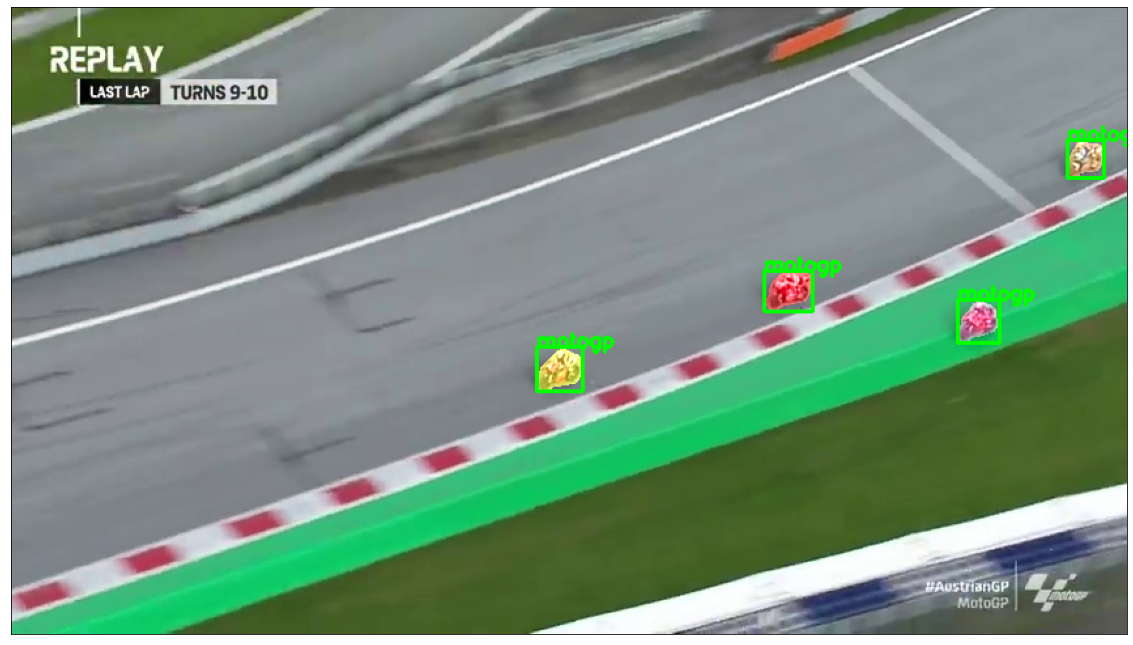

In [17]:
segment_instance('Motogp/MotoImages/motogp2020.mp4-frame04225_0170.jpg', confidence=0.9)